In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import shap
import glob
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
import shap
from sklearn.ensemble import ExtraTreesRegressor

In [37]:
#load files
shap_val = sorted(glob.glob('C:/Users/miche/Documents/Pesquisa/Shadow Economy/Data/shap*.npy')) #SHAP values
df = pd.read_csv('data/df_shadow_econ.csv')
models_names = ['Bagging','CatBoost','ExtraTrees','LightGBM','RF','Stacking','SVR','SymbReg','XGB']

In [44]:
#function for absolute SHAP value
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    df = pd.DataFrame(df)
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
       
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending = True)
    k2 = k2.tail(10)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs', color = colorlist, 
                      figsize=(8,5.5), 
                      legend=False)
    ax.set_xlabel("Absolute SHAP value (red = positive impact)")

In [39]:
#prepare data
df_train, df_test = train_test_split(df, random_state=0, test_size=0.2)
X = df_train.copy()
X = X.drop(['Shadow Economy'], axis=1)
X = X.rename(columns={'gdp_pc':'Log. GDP Per Capita'})
cols = X.columns
y = df_train['Shadow Economy']
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))

[8.  5.5]


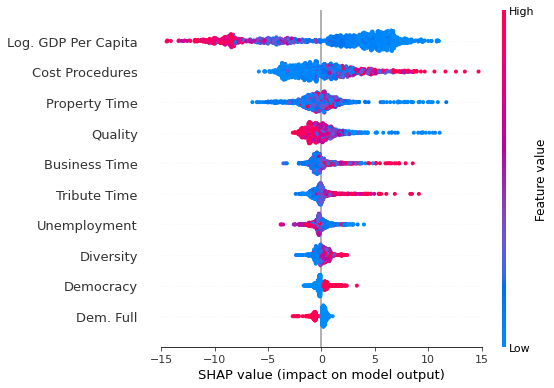

[8.  5.5]


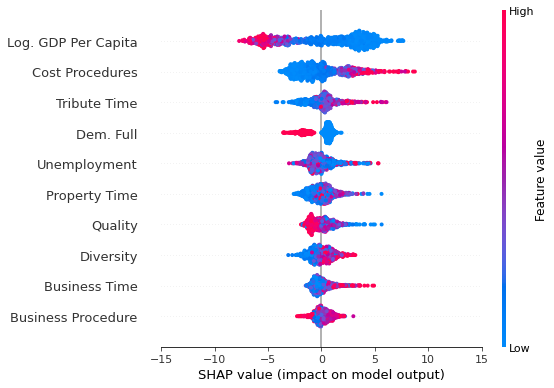

[8.  5.5]


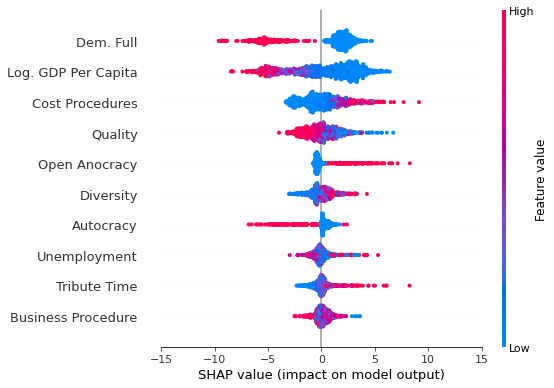

[8.  5.5]


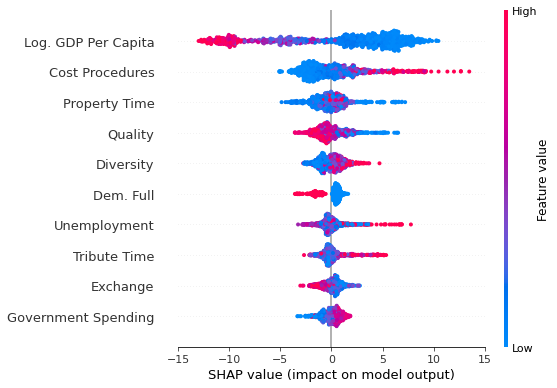

[8.  5.5]


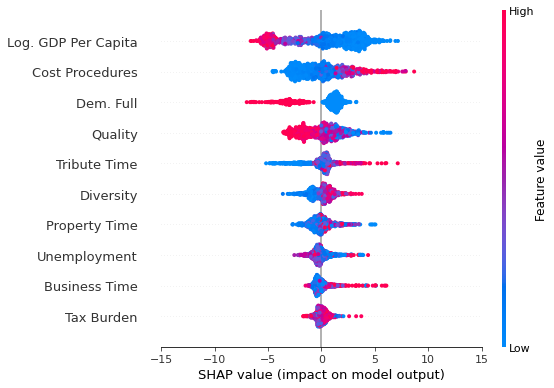

[8.  5.5]


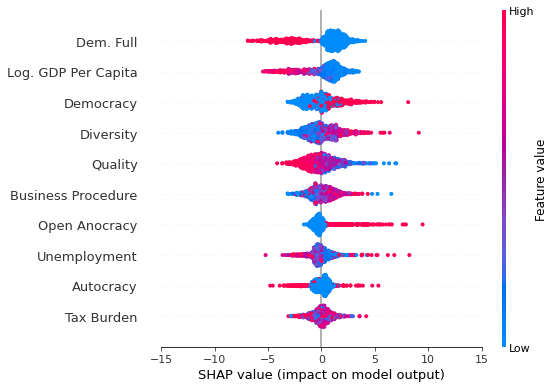

[8.  5.5]


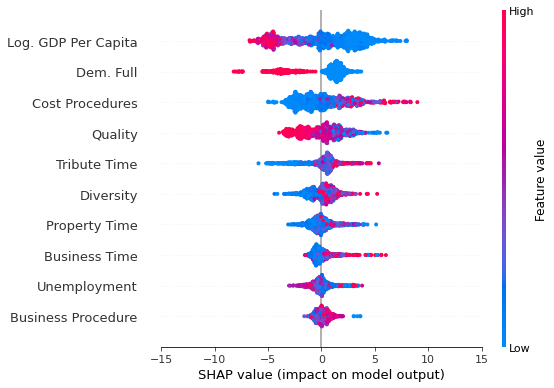

[8.  5.5]


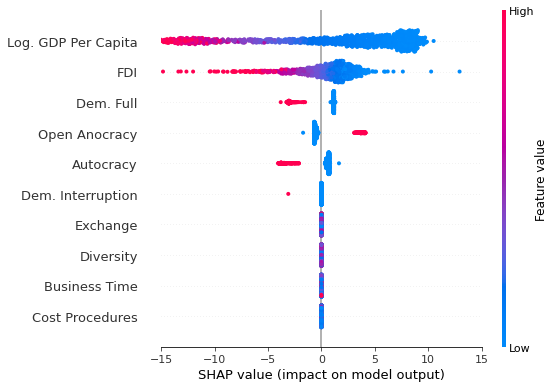

[8.  5.5]


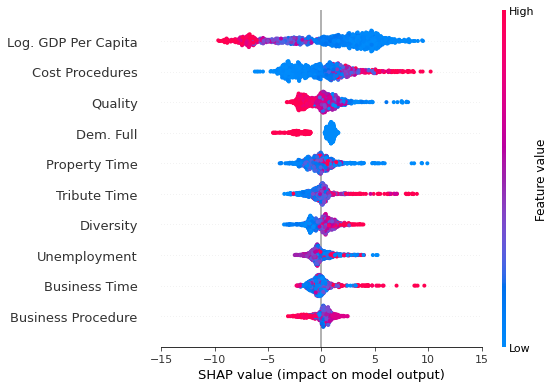

In [43]:
#bee swarm plots
for k in range (0,len(shap_val)):
    shap_values = np.load(shap_val[k])
    shap.summary_plot(shap_values, X, feature_names=cols, max_display=10, show=False)
    ax = plt.gca()
    ax.set_xlim(-15, 15)
    fig = plt.gcf()
    print(fig.get_size_inches())
    name = 'Figures/shap_swarm_'+str(models_names[k]+'.png')
    plt.savefig(name)
    plt.show()

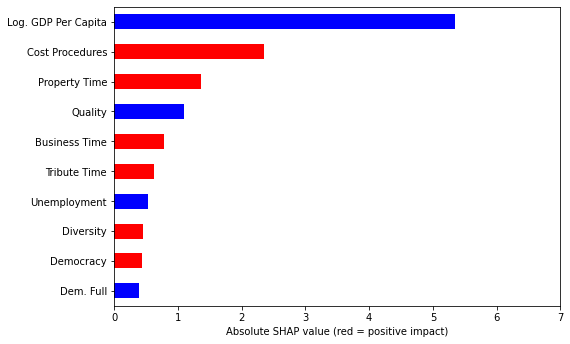

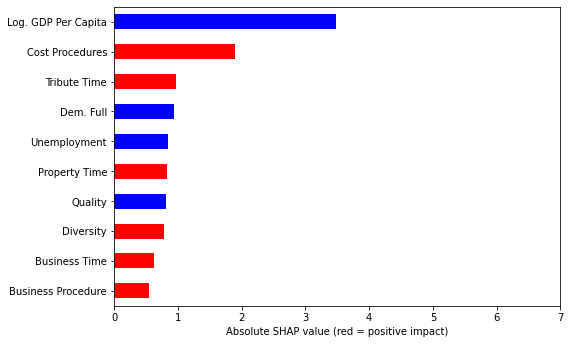

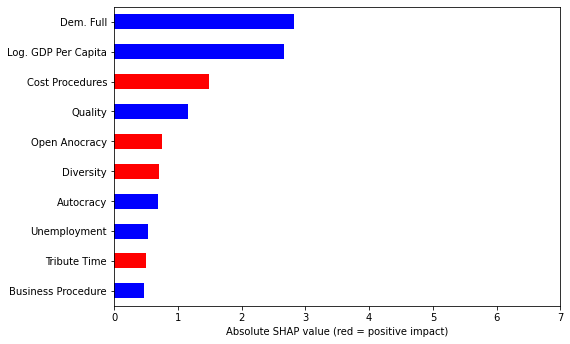

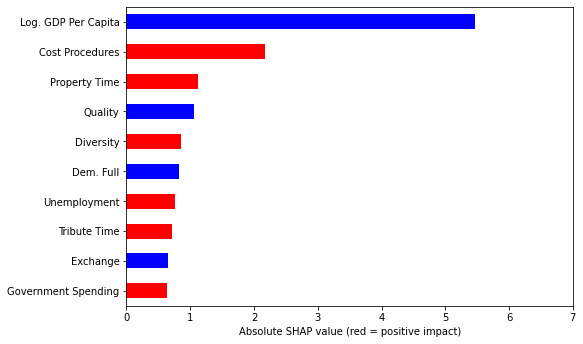

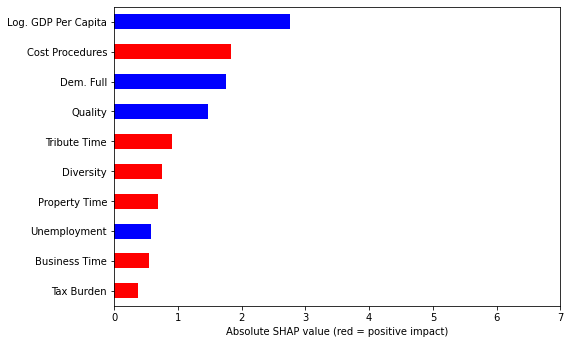

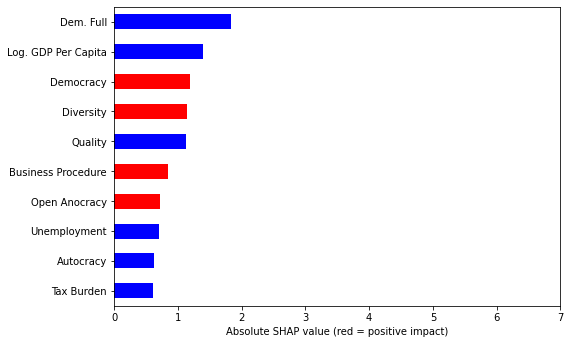

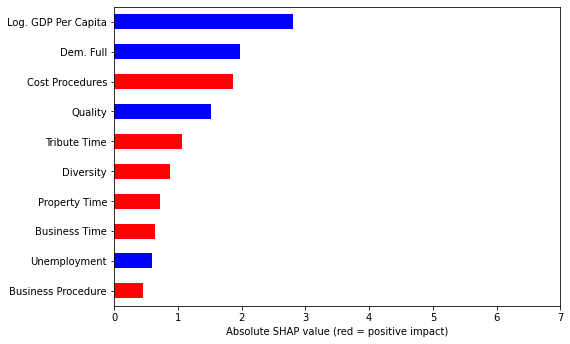

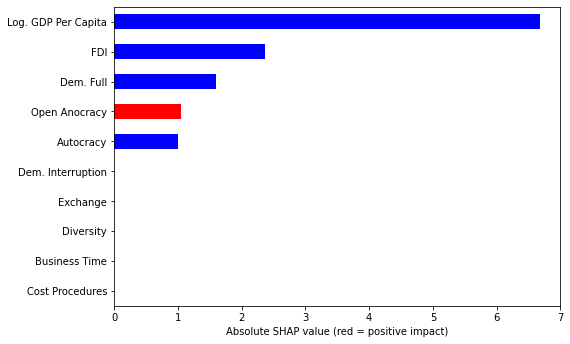

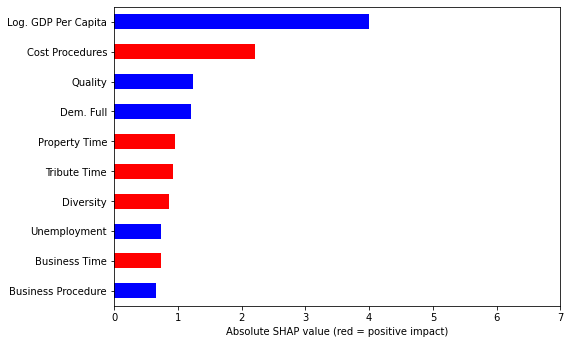

In [45]:
#abs value plots
X.columns = cols
for k in range (0,len(shap_val)):
    shap_values = np.load(shap_val[k])
    ABS_SHAP(shap_values, X)
    ax = plt.gca()
    ax.set_xlim(0, 7)
    ax.yaxis.label.set_visible(False)
    name = 'Figures/shap_abs_'+str(models_names[k]+'.png')
    plt.savefig(name, bbox_inches='tight')
    plt.show()

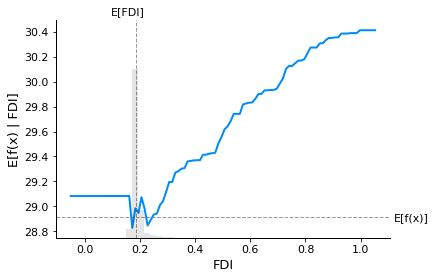

In [48]:
#partial dependence plot
model = ExtraTreesRegressor(bootstrap=False, max_features=0.35, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X,y)
shap.plots.partial_dependence('FDI', model.predict, X, ice=False, model_expected_value=True, 
                                      feature_expected_value=True)